# Dynamic and Friction Modelling Using PINN
System: Double Torsion Pendulum

In [129]:
# Import Packages
import tensorflow as tf
from tensorflow.keras.constraints import Constraint
from numpy.random import seed
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from derivative import dxdt
from time import time

# setting the seed
tf.random.set_seed(100)
seed(10)

In [130]:
# Data acquired from double torsion pendulum system
data = pd.read_csv('C:/Users/Samual/OneDrive - aucegypt.edu/Documents/PYTHON/Double Torsion Pendulum/Exp2_data_400_15_true_new.csv')
print(data.shape)

(4965, 8)


In [131]:
# Data Preprocessing

# Extract a portion of the data where the measured time series signals are steady
exp_data=data.iloc[2500:2950,:]
print(exp_data.shape)

exp_data.columns = ['time1', 'column angular position','time2', 'disk angular position','time1_raw', 'column angular position_raw','time2_raw', 'disk angular position_raw']
time1=(exp_data["time1"]-2600)*0.005
t=np.array(time1)
phi1=exp_data["column angular position"]
phi1=np.array(phi1)

# Differentiation method: Finite differences with central differencing using 3 points.
dphi1 = dxdt(phi1, t, kind="finite_difference", k=1)
ddphi1 = dxdt(dphi1, t, kind="finite_difference", k=1)

l=450 # Length of the data
t=t.reshape(l,1)
phi1=phi1.reshape(l,1)
ddphi1=ddphi1.reshape(l,1)

phi2=exp_data["disk angular position"]
phi2=np.array(phi2)
phi2=phi2.reshape(l,1)

# Training dataset
t_tr= t[0:2950:5]
phi1_tr = phi1[0:2950:5]
dphi1_tr = dphi1[0:2950:5]
ddphi1_tr = ddphi1[0:2950:5]
phi2_tr = phi2[0:2950:5]

# Test dataset
t_ts= t
phi1_ts = phi1
dphi1_ts = dphi1
ddphi1_ts = ddphi1
phi2_ts = phi2

(450, 8)


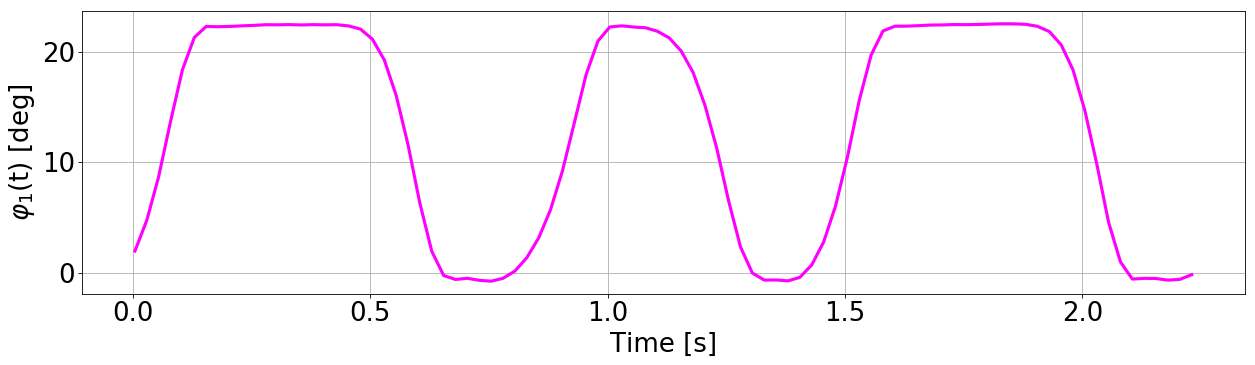

In [132]:
# Input Signal-- The angular position of the column pendulum
fig=plt.figure(figsize=(20,5),dpi=75)
plt.rcParams.update ({"font.size":25})
plt.plot(t_tr,phi1_tr,linewidth=3,color='magenta')
plt.ylabel('$φ_1$(t) [deg]')
plt.xlabel('Time [s]')
plt.grid(True)
plt.show()
print('\n')
fig.savefig("Column angular position plot.png",bbox_inches = "tight")
fig.savefig("Column angular position plot.svg", format='svg', dpi=1200,bbox_inches = "tight")


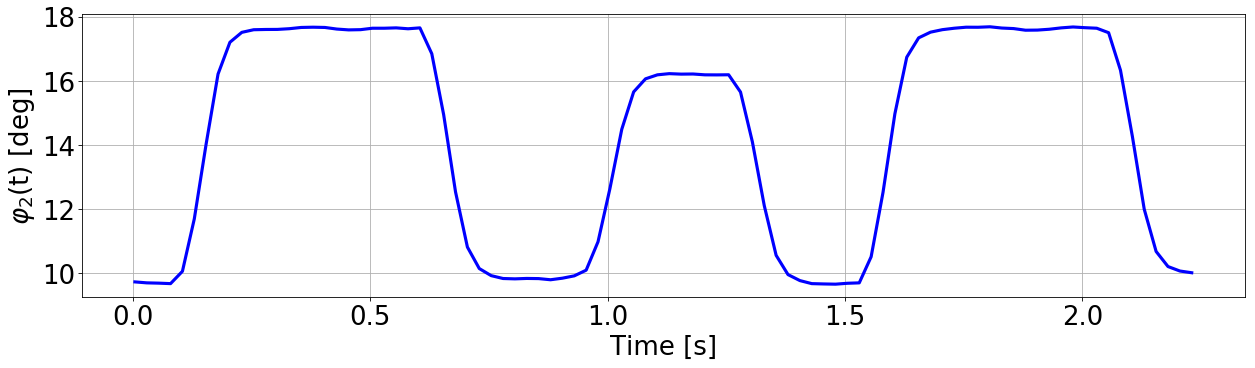

In [133]:
# Output Signal -- The angular position of the disk pendulum
fig=plt.figure(figsize=(20,5),dpi=75)
plt.rcParams.update ({"font.size":25})
plt.plot(t_tr,phi2_tr,linewidth=3,color = "blue")
plt.ylabel('$φ_2$(t) [deg]')
plt.xlabel('Time [s]')
plt.grid(True)
plt.show()
print('\n')
fig.savefig("Disk angular position plot.png",bbox_inches = "tight")
fig.savefig("Disk angular position plot.svg", format='svg', dpi=1200,bbox_inches = "tight")

In [134]:
# Define model architecture
class Neural_Network1(tf.keras.Model):
    """ Set the basic architecture of the neural network model."""

    def __init__(self,
            output_dimension=1,
            no_of_hidden_layers=2, 
            no_of_neurons_per_layer=30,
            activation1='tanh',
            activation2='linear',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.no_of_hidden_layers = no_of_hidden_layers
        self.output_dimension = output_dimension
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(no_of_neurons_per_layer,
                             activation=tf.keras.activations.get(activation1),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.no_of_hidden_layers)]
        #self.out = tf.keras.layers.Dense(output_dimension)
        self.out = tf.keras.layers.Dense(output_dimension,activation=tf.keras.activations.get(activation2))
        
    def call(self, X):
        """Forward-pass through neural network."""
        for i in range(self.no_of_hidden_layers):
            Z = self.hidden[i](X)
        return self.out(Z)

In [135]:
# Define model architecture
class Neural_Network2(tf.keras.Model):
    """ Set the basic architecture of the neural network model."""

    def __init__(self,
            output_dimension=1,
            no_of_hidden_layers=2, 
            no_of_neurons_per_layer=30,
            activation1='tanh',
            activation2='linear',
            kernel_initializer='glorot_normal',
            **kwargs):
        super().__init__(**kwargs)

        self.no_of_hidden_layers = no_of_hidden_layers
        self.output_dimension = output_dimension
        
        # Define NN architecture
        self.hidden = [tf.keras.layers.Dense(no_of_neurons_per_layer,
                             activation=tf.keras.activations.get(activation1),
                             kernel_initializer=kernel_initializer)
                           for _ in range(self.no_of_hidden_layers)]
        #self.out = tf.keras.layers.Dense(output_dimension)
        self.out = tf.keras.layers.Dense(output_dimension,activation=tf.keras.activations.get(activation2))
        
    def call(self, X):
        """Forward-pass through neural network."""
        for i in range(self.no_of_hidden_layers):
            Z = self.hidden[i](X)
        return self.out(Z)

In [138]:
class MinMaxConstraint(Constraint):
    """constrain model weights between [x_min, x_max]."""
    def __init__(self, x_min=0.0, x_max=1.0):
        super().__init__()
        self.x_min = x_min
        self.x_max = x_max
        # TODO: add sanity check if x_max == x_min or w_max == w_min
    
    def __call__(self, w):
        w_min = tf.minimum(tf.math.reduce_min(w), self.x_min)
        w_max = tf.maximum(tf.math.reduce_max(w), self.x_max)
        scale = (self.x_max - self.x_min) / (w_max - w_min)
        m = self.x_min - w_min * scale
        w = w * scale
        return w + m

In [139]:
class Neural_Network1_Param_Identification(Neural_Network1):
    def __init__(self, *args, **kwargs):
        
        # Call init of base class
        super().__init__(*args,**kwargs)

        self.J1 = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.001,0.003))
        self.J2 = tf.Variable(1.0, trainable=True, dtype='float32',constraint=MinMaxConstraint(0.0002,0.0005))
        self.J1_list = []
        self.J2_list = []

In [141]:
t_tr = tf.constant(t_tr,  dtype='float32')
phi1_tr= tf.constant(phi1_tr,  dtype='float32')

def get_derivatives(model1,model2,t_tr,phi1_tr):
     with tf.GradientTape() as tape0:
         tape0.watch(t_tr)
         with tf.GradientTape() as tape1:
             tape1.watch(phi1_tr)
             tape1.watch(t_tr)
             phi2_hat= model1(tf.stack([t_tr[:,0], phi1_tr[:,0]], axis=1))
             Ff_hat= model2(tf.stack([t_tr[:,0],phi1_tr[:,0]], axis=1))
             dphi2_hat = tape1.gradient(phi2_hat,t_tr)
        #tape0.watch(dphi2_hat)
         ddphi2_hat = tape0.gradient(dphi2_hat,t_tr)  
         return  phi2_hat, Ff_hat,ddphi2_hat

# Comupting the Model Losses
def compute_all_losses(model1,model2,t_tr,phi1_tr,J1,J2):
    
    # Compute the reduals of the system equations and the approximate solution losses
    phi2_hat, Ff_hat,ddphi2_hat= get_derivatives(model1,model2,t_tr,phi1_tr)
    r1_loss = (J1*ddphi1_tr)-(J2*ddphi2_hat)-Ff_hat
    loss1  =  tf.reduce_mean(tf.square((r1_loss)))
    loss2 = tf.reduce_mean(tf.square(phi2_hat-phi2_tr))
    loss_1=loss1
    loss_2=loss2

    return loss_1,loss_2

In [142]:
def get_gradients(model1,model2,t_tr,phi1_tr,J1,J2):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with respect to trainable variables
        tape.watch(model2.trainable_variables)
        tape.watch(model1.trainable_variables)
        loss_1,loss_2 = compute_all_losses(model1,model2,t_tr,phi1_tr,J1,J2)
        
    g2 = tape.gradient(loss_2, model1.trainable_variables)
    g1 = tape.gradient(loss_1, model2.trainable_variables)
    
    del tape

    return loss_1, loss_2,g1, g2
    

In [143]:
# Initialize model
model2 = Neural_Network1_Param_Identification()
model1 = Neural_Network2()
model1.build(input_shape=(None,2))
model2.build(input_shape=(None,2))

# Choose the optimizer
optim = tf.keras.optimizers.Adam(lr=0.01, decay=1e-6)

In [144]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss_1,loss_2, grad_Ff, grad_phi2 = get_gradients(model1,model2,t_tr,phi1_tr,model2.J1,model2.J2)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_phi2, model1.trainable_variables))
    optim.apply_gradients(zip(grad_Ff, model2.trainable_variables))
    loss_n=loss_1+loss_2
    return loss_n

# Number of training epochs
N = 10000
hist = []
# Start timer
t0 = time()
for j in range(N+1):
    
    loss_n = train_step()
    # Append current loss to hist
    hist.append(loss_n.numpy())
    J1= model2.J1.numpy()
    model2.J1_list.append(J1)
    J2= model2.J2.numpy()
    model2.J2_list.append(J2)

    # Output current loss after 50 iterates
    if j%50 == 0:
        print('It {:05d}: loss = {:6.4e}  J1 = {:6.4e}   J2 = {:6.4e}'.format(j,loss_n,J1,J2))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 2.2822e+06  J1 = 3.0000e-03   J2 = 5.0000e-04
It 00050: loss = 9.8883e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00100: loss = 9.0011e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00150: loss = 8.6385e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00200: loss = 8.4227e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00250: loss = 8.2624e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00300: loss = 8.1314e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00350: loss = 8.0056e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00400: loss = 7.8994e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00450: loss = 7.8090e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00500: loss = 7.7244e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00550: loss = 7.6454e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00600: loss = 7.5726e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00650: loss = 7.5052e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00700: loss = 7.4454e+00  J1 = 1.0000e-03   J2 = 2.0000e-04
It 00750: loss = 7.3818e+00  J1 = 1.0000e-03   J2 = 2.0

In [150]:
print("The identified value of J1:",J1, "and J2:",J2)

The identified value of J1: 0.0010000002 and J2: 0.00019999998


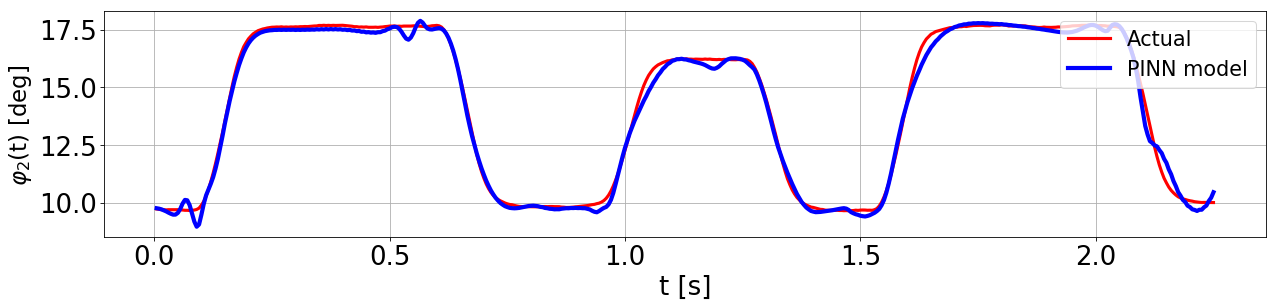

In [151]:
# Prediction with the new (test) data
phi2_new= model1(tf.stack([t_ts[:,0], phi1_ts[:,0]], axis=1)) 
Ff_new= model2(tf.stack([t_ts[:,0], phi1_ts[:,0]], axis=1)) 


fig=plt.figure(figsize=(20,4),dpi=75)
plt.rcParams.update ({"font.size":25})
plt.plot(t_ts, phi2_ts, color='r',linewidth=3,label="Actual")
plt.plot(t_ts, phi2_new, color='b',linewidth=4,label="PINN model")
plt.ylabel('$φ_2$(t) [deg] ',fontsize=22)
plt.xlabel('t [s]',fontsize=25)
plt.legend(loc=1, prop={'size': 20})
plt.grid(True)
plt.show()
fig.savefig("PINN phi2.png",bbox_inches = "tight")
fig.savefig("PINN phi2.svg",dpi=1200,bbox_inches = "tight")

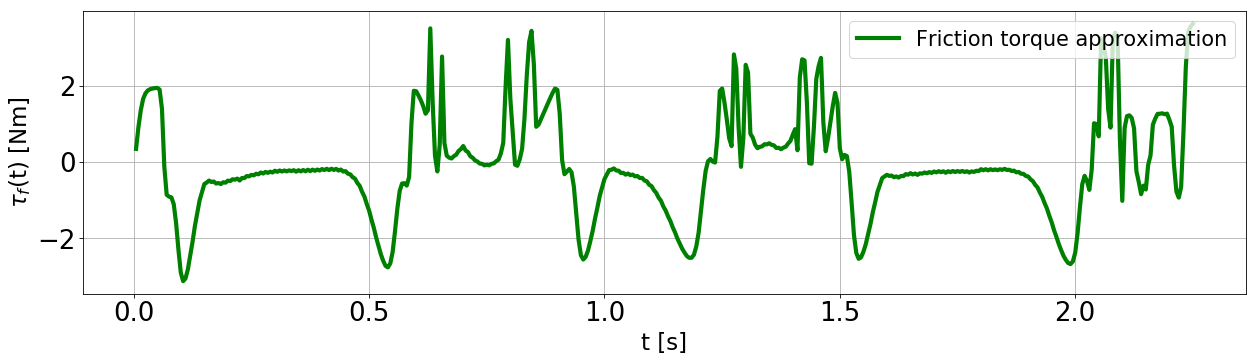

In [152]:
# Prediction with the new (test) data
phi2_new= model1(tf.stack([t_ts[:,0], phi1_ts[:,0]], axis=1)) 
Tf_new= model2(tf.stack([t_ts[:,0], phi1_ts[:,0]], axis=1)) 


fig=plt.figure(figsize=(20,5),dpi=75)
plt.rcParams.update ({"font.size":25})
plt.plot(t_ts, Tf_new, color='g',linewidth=4,label="Friction torque approximation")
plt.ylabel(r'$\tau_{f}$(t) [Nm]',fontsize=22)
plt.xlabel('t [s]',fontsize=22)
plt.legend(loc=1, prop={'size': 20})
plt.grid(True)
plt.show()
fig.savefig("PINN friction torque.png",bbox_inches = "tight")
fig.savefig("PINN friction torque.svg",dpi=1200,bbox_inches = "tight")

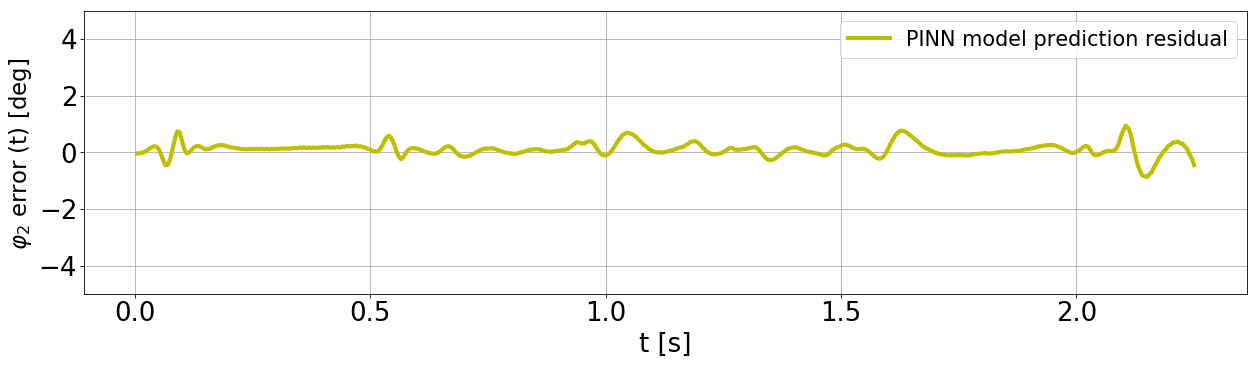

In [153]:
fig=plt.figure(figsize=(20,5),dpi=75)
plt.rcParams.update ({"font.size":25})
plt.plot(t_ts, (phi2-phi2_new), color='y',linewidth=4,label="PINN model prediction residual")
plt.ylabel(r'$φ_2$ error (t) [deg] ',fontsize=22)
plt.xlabel('t [s]',fontsize=25)
plt.ylim(-5, 5)
plt.legend(loc=1, prop={'size': 20})
plt.grid(True)
plt.show()
fig.savefig("prediction error.png",bbox_inches = "tight")
fig.savefig("prediction error.svg",dpi=1200,bbox_inches = "tight")